In [1]:
import numpy as np
import pandas as pd
import re
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.rk import RK45
import matplotlib.pyplot as plt


### Dummy Coupled ODE System

Let the state vector be $\mathbf{H}(t) = [H_0, H_1, H_2, H_3, H_4]$. The system is defined as:

$$
\begin{aligned}
\frac{dH_0}{dt} &= X_0 - Y_0 \\
\frac{dH_1}{dt} &= X_1 + Y_0(H_0) - X_2(H_1) - Y_1 - I_2 \\
\frac{dH_2}{dt} &= X_2(H_1) - Y_2 \\
\frac{dH_3}{dt} &= I_2(H_1) - I_3(H_3) - Y_3 \\
\frac{dH_4}{dt} &= I_3(H_3) - Y_4
\end{aligned}
$$

---

### Dummy Inputs Used

The inputs are modeled as simple functions or constants:

* $X_0 = 1.0$
* $Y_0 = 0.5 \cdot H_0$
* $X_1 = 1.2$
* $X_2 = 0.3 \cdot H_1$
* $I_2 = 0.6$
* $I_3 = 0.4 \cdot H_3$
* $Y_1 = 0.4$
* $Y_2 = 0.2$
* $Y_3 = 0.3$
* $Y_4 = 0.1$



In [2]:
# Define the ODE right-hand side function
def rhs(t, y):
    H0, H1, H2, H3, H4 = y

    # Dummy inputs/constants
    X0 = 1.0
    Y0 = 0.5 * H0

    X1 = 1.2
    X2 = 0.3 * H1
    Y1 = 0.4
    Y2 = 0.2
    Y3 = 0.3
    Y4 = 0.1

    I2 = 0.6 * H1
    I3 = 0.4 * H3

    dH0 = X0 - Y0
    dH1 = X1 + Y0 - X2 - Y1 - I2
    dH2 = X2 - Y2
    dH3 = I2 - I3 - Y3
    dH4 = I3 - Y4

    return [dH0, dH1, dH2, dH3, dH4]

# Set time span and evaluation grid
t_span = (0.0, 5.0)
t_eval = np.linspace(*t_span, 500)
t_fine = np.linspace(*t_span, 1000)

# Initial conditions for the first solves
initial_conditions = [1.0, 1.0, 1.0, 1.0, 1.0]

In [3]:
# Function to plot multiple H‐variables over time
def plot_time_series(sol, labels, title):
    plt.figure(figsize=(10, 6))
    for i, lbl in enumerate(labels):
        plt.plot(sol.t, sol.y[i], label=lbl)
    plt.xlabel('Time')
    plt.ylabel('State Variables')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

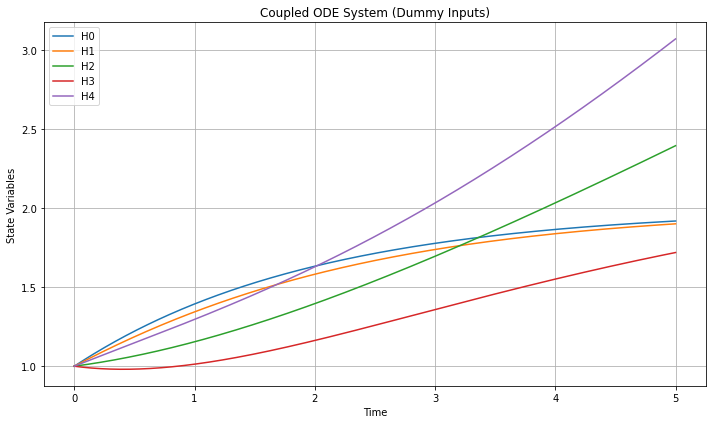

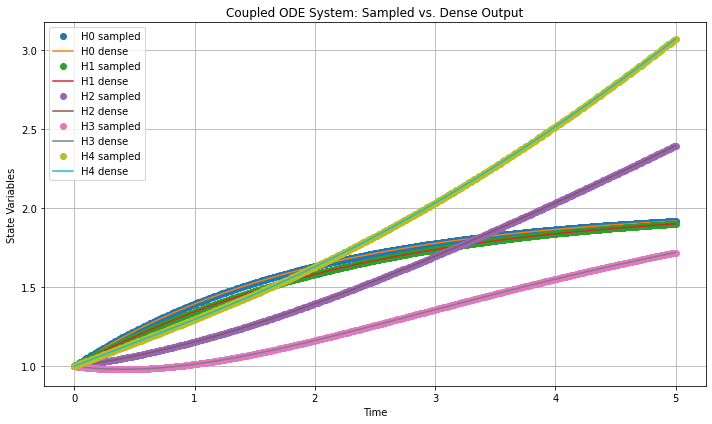

In [4]:
# Solve the ODE once and plot
sol_initial = solve_ivp(
    rhs,
    t_span,
    initial_conditions,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9
)
labels = [f"H{i}" for i in range(5)]
plot_time_series(sol_initial, labels, "Coupled ODE System (Dummy Inputs)")

# Solve again with dense output and compare sampled vs. dense
sol_dense = solve_ivp(
    rhs,
    t_span,
    initial_conditions,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
y_dense = sol_dense.sol(np.linspace(*t_span, 2000))

plt.figure(figsize=(10, 6))
for i, lbl in enumerate(labels):
    plt.plot(sol_dense.t, sol_dense.y[i], 'o', label=f"{lbl} sampled")
    plt.plot(np.linspace(*t_span, 2000), y_dense[i], '-', label=f"{lbl} dense")
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Coupled ODE System: Sampled vs. Dense Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

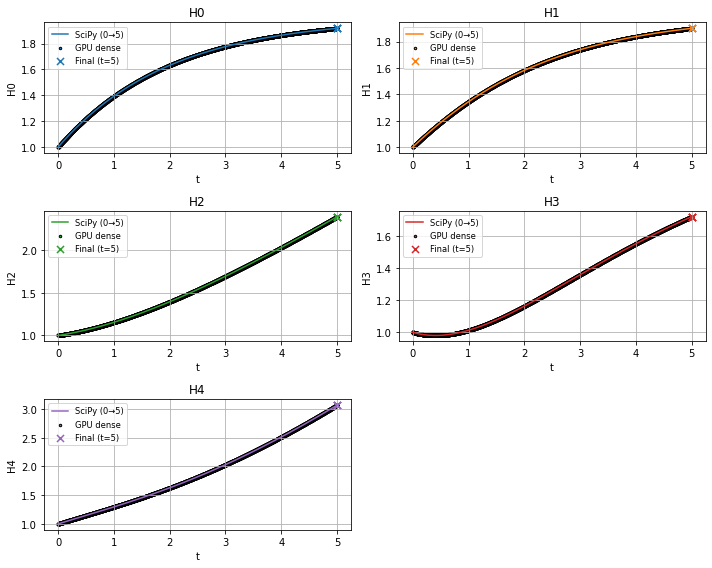

In [5]:
# Load GPU‐dense output from CSV
dense_df = pd.read_csv("dense.csv")
col_prefix = "Var"  # columns named Var0_sys0, Var1_sys0, …, Var4_sys0
times_gpu = dense_df["time"].values

# Build H_gpu_tau0 for system 0
H_gpu_tau0 = np.vstack([
    dense_df[f"{col_prefix}{i}_sys0"].values
    for i in range(5)
]).T  # shape = (N_rows, 5)

# Solve the ODE with SciPy on [0,5], using the GPU initial state for system 0
y0 = H_gpu_tau0[0]
sol = solve_ivp(
    rhs,
    t_span,
    y0,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
Y_fine = sol.sol(t_fine).T  # shape = (1000, 5)

# Load final.csv and build H_final
final_df = pd.read_csv("final.csv")
H_final = np.vstack([
    final_df[f"{col_prefix}{i}"].values
    for i in range(5)
]).T  # shape = (n_rows, 5)
n_rows = H_final.shape[0]
times_final = np.full(n_rows, t_span[1])  

# Plot SciPy curve, GPU dense markers, and final values at t=5 for system 0
plt.figure(figsize=(10, 8))
for i in range(5):
    ax = plt.subplot(3, 2, i + 1)
    ax.plot(
        t_fine,
        Y_fine[:, i],
        "-",
        label="SciPy (0→5)",
        color=f"C{i}"
    )
    ax.scatter(
        times_gpu,
        H_gpu_tau0[:, i],
        s=6,
        label="GPU dense",
        color=f"C{i}",
        edgecolor="k"
    )
    ax.scatter(
        times_final,
        H_final[:, i],
        s=50,
        marker="x",
        label="Final (t=5)",
        color=f"C{i}"
    )
    ax.set_title(f"H{i}")
    ax.set_xlabel("t")
    ax.set_ylabel(f"H{i}")
    ax.legend(fontsize="small")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Solve from GPU‐initial state and compare to SciPy final
y0_gpu = H_gpu_tau0[0]
sol_gpu_init = solve_ivp(
    rhs,
    t_span,
    y0_gpu,
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    dense_output=True
)
H_scipy_final = sol_gpu_init.sol(t_span[1])
H_gpu_final = H_final[0]

print("SciPy final at t=5:     ", H_scipy_final)
print("GPU final  from CSV:    ", H_gpu_final)

abs_err = np.abs(H_gpu_final - H_scipy_final)
rel_err = abs_err / (np.abs(H_scipy_final) + 1e-16)

print("\nAbsolute errors:")
for i in range(5):
    print(f" H{i}: {abs_err[i]:.2e}")

print("\nRelative errors:")
for i in range(5):
    print(f" H{i}: {rel_err[i]:.2e}")

SciPy final at t=5:      [1.91793531 1.90019549 2.39415638 1.7187984  3.06951436]
GPU final  from CSV:     [1.91791 1.90017 2.39397 1.71872 3.06922]

Absolute errors:
 H0: 2.53e-05
 H1: 2.55e-05
 H2: 1.86e-04
 H3: 7.84e-05
 H4: 2.94e-04

Relative errors:
 H0: 1.32e-05
 H1: 1.34e-05
 H2: 7.78e-05
 H3: 4.56e-05
 H4: 9.59e-05



Steps taken by SciPy RK45: 12
Detected 4 system(s), 5 variable(s)


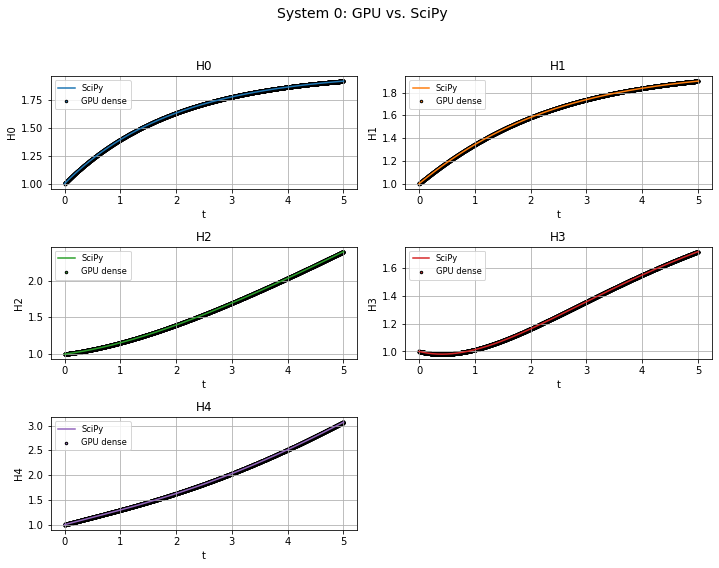

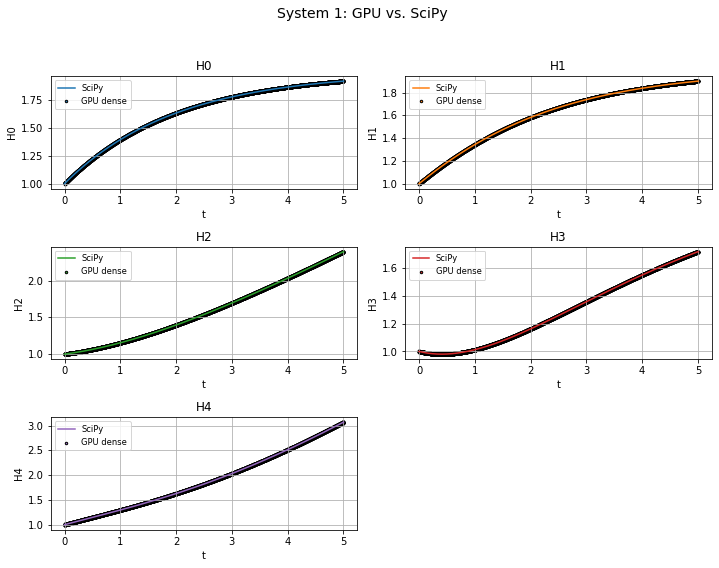

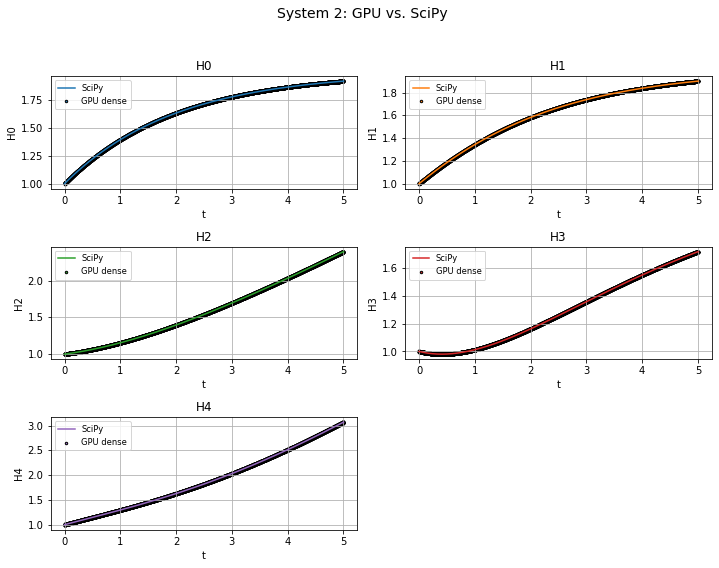

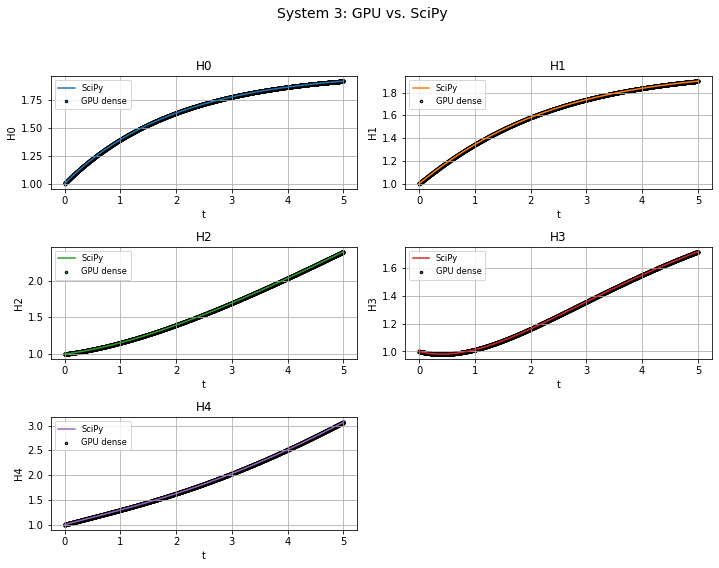

In [7]:
# Detailed GPU vs. SciPy for each system
n_scipy_steps = len(sol_gpu_init.t)
print(f"\nSteps taken by SciPy RK45: {n_scipy_steps}")

col_regex = re.compile(r"([A-Za-z]+)(\d+)_sys(\d+)")
systems = {}
for col in dense_df.columns:
    m = col_regex.fullmatch(col)
    if not m:
        continue
    var_idx = int(m.group(2))
    sys_idx = int(m.group(3))
    systems.setdefault(sys_idx, {})[var_idx] = col

num_systems = len(systems)
num_vars = max(len(v) for v in systems.values())
print(f"Detected {num_systems} system(s), {num_vars} variable(s)")

t_fine = np.linspace(*t_span, 1000)
for s_idx, col_map in systems.items():
    H_gpu_s = np.vstack([dense_df[col_map[i]].values for i in range(num_vars)]).T
    y0_s = H_gpu_s[0]

    sol_s = solve_ivp(
        rhs,
        t_span,
        y0_s,
        method="RK45",
        rtol=1e-6,
        atol=1e-9,
        dense_output=True
    )
    Y_fine_s = sol_s.sol(t_fine).T

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"System {s_idx}: GPU vs. SciPy", fontsize=14)
    for i in range(num_vars):
        ax = plt.subplot(3, 2, i + 1)
        ax.plot(t_fine, Y_fine_s[:, i], "-", label="SciPy", color=f"C{i}")
        ax.scatter(times_gpu, H_gpu_s[:, i], s=6,
                   label="GPU dense", color=f"C{i}", edgecolor="k")
        ax.set_title(f"H{i}")
        ax.set_xlabel("t")
        ax.set_ylabel(f"H{i}")
        ax.legend(fontsize="small")
        ax.grid(True)

    if num_vars < 6:
        plt.subplot(3, 2, 6).axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Steps taken by SciPy RK45: 12
Detected 4 system(s), 5 variable(s)


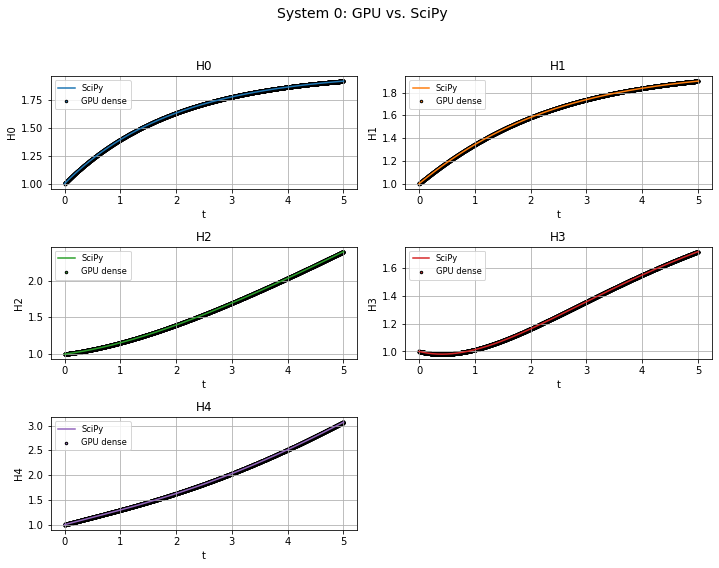

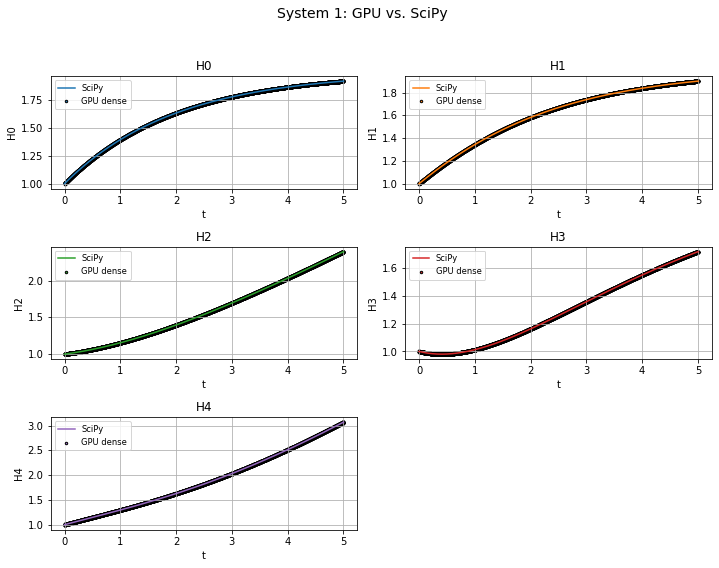

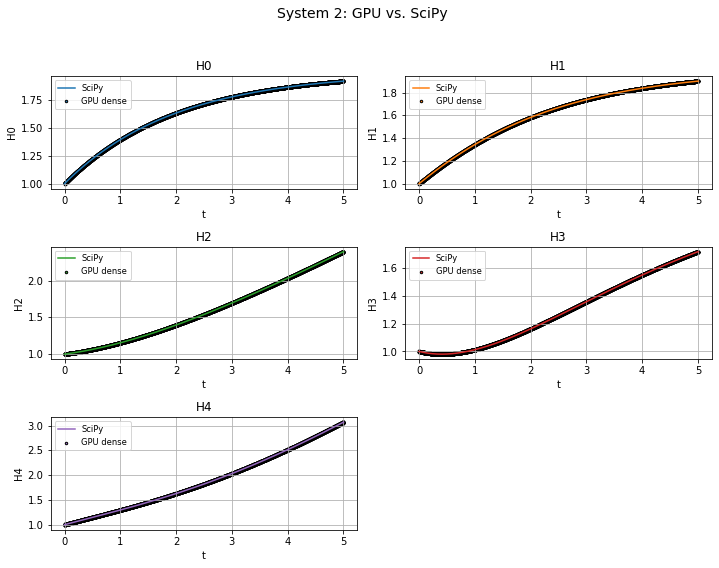

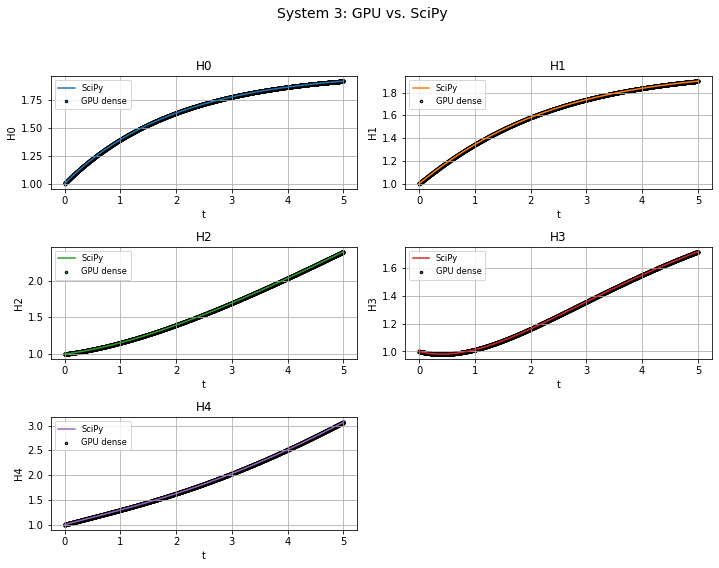

In [8]:
# Detailed GPU vs. SciPy for each system
n_scipy_steps = len(sol_gpu_init.t)
print(f"\nSteps taken by SciPy RK45: {n_scipy_steps}")

col_regex = re.compile(r"([A-Za-z]+)(\d+)_sys(\d+)")
systems = {}
for col in dense_df.columns:
    m = col_regex.fullmatch(col)
    if not m:
        continue
    var_idx = int(m.group(2))
    sys_idx = int(m.group(3))
    systems.setdefault(sys_idx, {})[var_idx] = col

num_systems = len(systems)
num_vars = max(len(v) for v in systems.values())
print(f"Detected {num_systems} system(s), {num_vars} variable(s)")

t_fine = np.linspace(*t_span, 1000)
for s_idx, col_map in systems.items():
    H_gpu_s = np.vstack([dense_df[col_map[i]].values for i in range(num_vars)]).T
    y0_s = H_gpu_s[0]

    sol_s = solve_ivp(
        rhs,
        t_span,
        y0_s,
        method="RK45",
        rtol=1e-6,
        atol=1e-9,
        dense_output=True
    )
    Y_fine_s = sol_s.sol(t_fine).T

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"System {s_idx}: GPU vs. SciPy", fontsize=14)
    for i in range(num_vars):
        ax = plt.subplot(3, 2, i + 1)
        ax.plot(t_fine, Y_fine_s[:, i], "-", label="SciPy", color=f"C{i}")
        ax.scatter(times_gpu, H_gpu_s[:, i], s=6,
                   label="GPU dense", color=f"C{i}", edgecolor="k")
        ax.set_title(f"H{i}")
        ax.set_xlabel("t")
        ax.set_ylabel(f"H{i}")
        ax.legend(fontsize="small")
        ax.grid(True)

    if num_vars < 6:
        plt.subplot(3, 2, 6).axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


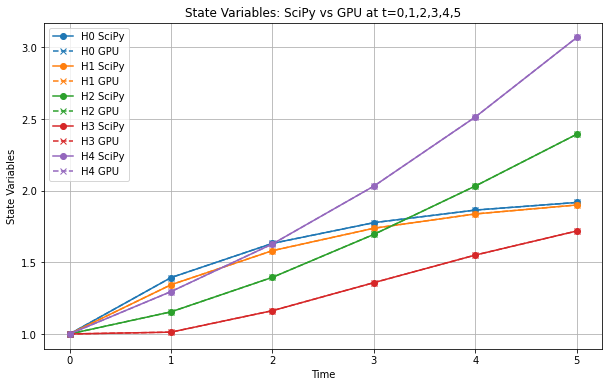

SciPy’s initial step h0 = 0.03150529000008159


In [9]:
# Times at which to compare SciPy vs. GPU
times_to_compare = np.array([0, 1, 2, 3, 4, 5])

# Solve with SciPy at those exact times
y0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
sol_cmp = solve_ivp(
    rhs,
    (0, 5),
    y0,
    t_eval=times_to_compare,
    method='RK45',
    rtol=1e-6,
    atol=1e-9
)

# Build a DataFrame of SciPy results
scipy_results = pd.DataFrame(sol_cmp.y.T, columns=[f'H{i}' for i in range(5)])
scipy_results['time'] = times_to_compare

# Prepare GPU results at those same times
gpu_data = []
nearest_times = []
system_index = 0  # compare system 0

for t in times_to_compare:
    if t == 0:
        gpu_row = [1.0] * 5
        nt = 0.0
    elif t == 5:
        gpu_row = final_df.loc[0, [f'{col_prefix}{i}' for i in range(5)]].values.tolist()
        nt = 5.0
    else:
        idx = (np.abs(dense_df['time'] - t)).idxmin()
        row = dense_df.loc[idx]
        gpu_row = [row[f'{col_prefix}{i}_sys{system_index}'] for i in range(5)]
        nt = row['time']

    gpu_data.append(gpu_row)
    nearest_times.append(nt)

gpu_results = pd.DataFrame(gpu_data, columns=[f'H{i}_gpu' for i in range(5)])
gpu_results['time'] = times_to_compare
gpu_results['nearest_time'] = nearest_times

# Merge SciPy vs GPU into one table
comparison_df = scipy_results.merge(gpu_results, on='time')

# Compute absolute and relative errors
for i in range(5):
    comparison_df[f'abs_err_H{i}'] = np.abs(comparison_df[f'H{i}'] - comparison_df[f'H{i}_gpu'])
    comparison_df[f'rel_err_H{i}'] = comparison_df[f'abs_err_H{i}'] / np.abs(comparison_df[f'H{i}'])

# Save comparison table to CSV
comparison_df.set_index('time', inplace=True)
comparison_df.to_csv("comparison.csv")

# Plot SciPy vs GPU at t=0,1,2,3,4,5 
plt.figure(figsize=(10, 6))
for i in range(5):
    color = f"C{i}"
    plt.plot(
        scipy_results['time'],
        scipy_results[f'H{i}'],
        marker='o',
        color=color,
        label=f'H{i} SciPy'
    )
    plt.plot(
        gpu_results['time'],
        gpu_results[f'H{i}_gpu'],
        marker='x',
        linestyle='--',
        color=color,
        label=f'H{i} GPU'
    )

plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('State Variables: SciPy vs GPU at t=0,1,2,3,4,5')
plt.legend()
plt.grid(True)
plt.savefig('test.png')
plt.show()

# Get SciPy’s initial RK45 step size (h_abs)
solver = RK45(rhs, 0.0, y0, 5.0, rtol=1e-6, atol=1e-9)
h0 = solver.h_abs
print("SciPy’s initial step h0 =", h0)


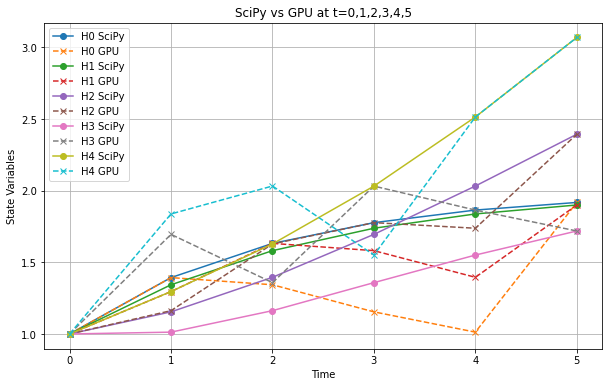

SciPy’s initial step h0 = 0.03150529000008159


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, RK45

# ───────── User‐provided ODE and time‐grid ─────────
# def rhs(t, y): ...
t_span = (0.0, 5.0)
times_to_compare = np.array([0, 1, 2, 3, 4, 5])

# ───────── 1) Load GPU data ─────────
# Dense interior points
dense_df  = pd.read_csv("dense.csv")
col_prefix = "Var"
# Exact points at integer times (test.csv has its own header "time,Var0_sys0,...,Var4_sys3")
test_df   = pd.read_csv("test.csv")

# ───────── 2) Solve with SciPy at exactly t=0…5 ─────────
y0 = np.ones(5)
sol_cmp = solve_ivp(
    rhs,
    t_span,
    y0,
    t_eval=times_to_compare,
    method="RK45",
    rtol=1e-6,
    atol=1e-9
)

# Build SciPy DataFrame
scipy_results = pd.DataFrame(sol_cmp.y.T, columns=[f'H{i}' for i in range(5)])
scipy_results['time'] = sol_cmp.t

# ───────── 3) Extract GPU results at the same times ─────────
gpu_rows      = []
nearest_times = []
system_index  = 0

for t in times_to_compare:
    if t in test_df['time'].values:
        # Use the exact GPU output from test.csv
        row = test_df[test_df['time'] == t].iloc[0]
        gpu_vals = [row[f"{col_prefix}{i}_sys{system_index}"] for i in range(5)]
        nt = t
    else:
        # Fallback: find nearest interior point in dense.csv
        idx      = (dense_df['time'] - t).abs().idxmin()
        row      = dense_df.loc[idx]
        gpu_vals = [row[f"{col_prefix}{i}_sys{system_index}"] for i in range(5)]
        nt       = row['time']

    gpu_rows.append(gpu_vals)
    nearest_times.append(nt)

gpu_results = pd.DataFrame(
    gpu_rows,
    columns=[f'H{i}_gpu' for i in range(5)]
)
gpu_results['time'] = times_to_compare
gpu_results['nearest_time'] = nearest_times

# ───────── 4) Merge and compute errors ─────────
comparison_df = scipy_results.merge(gpu_results, on='time').set_index('time')

for i in range(5):
    H    = comparison_df[f'H{i}']
    Hgpu = comparison_df[f'H{i}_gpu']
    comparison_df[f'abs_err_H{i}'] = np.abs(H - Hgpu)
    comparison_df[f'rel_err_H{i}'] = comparison_df[f'abs_err_H{i}'] / np.abs(H)

# ───────── 5) Save to CSV ─────────
comparison_df.to_csv("comparison.csv")

# ───────── 6) (Optional) Plot SciPy vs GPU ─────────
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(
        scipy_results['time'],
        scipy_results[f'H{i}'],
        marker='o',
        label=f'H{i} SciPy'
    )
    plt.plot(
        gpu_results['time'],
        gpu_results[f'H{i}_gpu'],
        marker='x',
        linestyle='--',
        label=f'H{i} GPU'
    )
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('SciPy vs GPU at t=0,1,2,3,4,5')
plt.legend()
plt.grid(True)
plt.savefig('comparison.png')
plt.show()

# ───────── 7) SciPy’s initial RK45 step size ─────────
solver = RK45(rhs, 0.0, y0, t_span[1], rtol=1e-6, atol=1e-9)
print("SciPy’s initial step h0 =", solver.h_abs)


In [ ]:
## Linear ET for now 0.1*temp, later base it on HamonPET, make sure to check equations, th

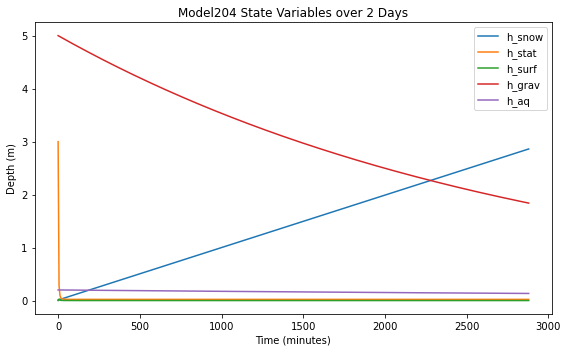

In [25]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ───────── Model204 RHS ─────────
# Implements the five-equation “snow, static, surface, grav, aquifer” runoff model.
def model204_rhs(t, y):
    # Unpack state variables
    h_snow, h_stat, h_surf, h_grav, h_aq = y

    # ─── stub spatial parameters (replace with real inputs later) ───
    c1     = 0.001 / 60.0
    infil  = 0.0001 * c1
    perco  = 0.00005 * c1
    Hu     = 0.5      # [m]
    lat    = 45.0     # [°]
    sw, ss = 0.2, 0.8
    n_mann = 0.03
    slope  = 0.05
    L      = 1000.0
    A_h    = 1e5
    alpha3 = 2 * 24 * 60  # [min]
    alpha4 = 5 * 24 * 60  # [min]
    melt_f = 0.00001
    temp_thr = 0.0        # [°C]

    # ─── stub forcings (replace with time‐series later) ───
    rainfall    = 0.001             # [m/min]
    temperature = 1.0               # [°C]
    doy         = 1.0 + t / 1440.0  # day-of-year

    # 1) Snow
    snowmelt = (temperature >= temp_thr) * min(h_snow, temperature * melt_f)
    x1       = rainfall + snowmelt
    dh_snow  = rainfall - snowmelt

    # 2) Static store
    x2      = max(0.0, x1 + h_stat - Hu)
    d1      = x1 - x2
    # ET stub: linear in temperature
    e_pot   = 0.1 * temperature    # stub for HamonPET
    Emax    = min(e_pot, h_stat)
    s       = h_stat / Hu
    out1    = s * Emax            # stub for ETactual
    dh_stat = d1 - out1

    # 3) Surface store
    x3      = min(x2, infil)
    d2      = x2 - x3
    alfa2   = (1.0 / n_mann) * h_surf**(2.0/3.0) * np.sqrt(slope)
    w       = min(1.0, alfa2 * L / A_h * 60.0)
    out2    = h_surf * w
    dh_surf = d2 - out2

    # 4) Gravitational (interflow)
    x4      = min(x3, perco)
    d3      = x3 - x4
    out3    = (h_grav / alpha3) if alpha3 >= 1.0 else 0.0
    dh_grav = d3 - out3

    # 5) Aquifer (baseflow)
    d4      = x4
    out4    = (h_aq / alpha4) if alpha4 >= 1.0 else 0.0
    dh_aq   = d4 - out4

    return [dh_snow, dh_stat, dh_surf, dh_grav, dh_aq]

# ───────── Simulation setup ─────────
# Integration interval [minutes]: 0 → 2 days
t0, tf = 0.0, 2*24*60
t_eval = np.linspace(t0, tf, 500)

# ───────── Initial conditions ─────────
#   h_snow = 0.01, h_stat = 0.10, h_surf = 0.00,
#   h_grav = 0.01, h_aq   = 0.00
#y0 = [h_snow, h_stat, h_surf, h_grav, h_aq]
#y0 = [0.01, 0.10, 0.00, 0.01, 0.00]
#y0 = [h_snow, h_stat, h_surf, h_grav, h_aq]
y0 = [0.01, 3, 0.00, 5, 0.20]

# ───────── Integrate with SciPy RK45 ─────────
sol = solve_ivp(
    model204_rhs,
    (t0, tf),
    y0,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9,
)

# ───────── Plot results ─────────
plt.figure(figsize=(8,5))
labels = ['h_snow','h_stat','h_surf','h_grav','h_aq']
for i, lab in enumerate(labels):
    plt.plot(sol.t, sol.y[i], label=lab)
plt.xlabel('Time (minutes)')
plt.ylabel('Depth (m)')
plt.title('Model204 State Variables over 2 Days')
plt.legend()
plt.tight_layout()
plt.show()


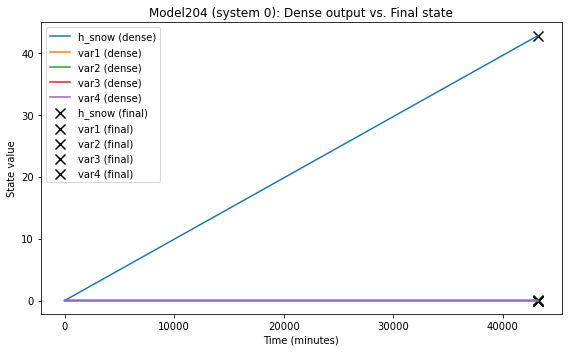

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSVs
dense_df = pd.read_csv('dense_204.csv')
final_df = pd.read_csv('final_204.csv')

time = dense_df["time"]

# Select only the system-0 columns from the dense output:
# they have the form var{i}_sys0
sys0_cols = [c for c in dense_df.columns if c.endswith("_sys0")]

plt.figure(figsize=(8,5))

# Plot each variable's dense time series for system 0
for col in sys0_cols:
    var_idx = int(col.split("_")[0][3:])  # "var0_sys0" -> 0
    var_name = "h_snow" if var_idx == 0 else f"var{var_idx}"
    plt.plot(time, dense_df[col], label=f"{var_name} (dense)")

# Overlay final state for system 0 as X's
t_last = time.iloc[-1]
for col in sys0_cols:
    var_idx = int(col.split("_")[0][3:])
    var_name = "h_snow" if var_idx == 0 else f"var{var_idx}"
    final_val = final_df[var_name].iloc[0]  # final_df has one row
    plt.scatter([t_last], [final_val],
                marker='x', s=100, color='black',
                label=f"{var_name} (final)")

plt.xlabel("Time (minutes)")
plt.ylabel("State value")
plt.title("Model204 (system 0): Dense output vs. Final state")
plt.legend()           # single legend with one entry per plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
dense_df = pd.read_csv('dense_204.csv')
final_df = pd.read_csv('final_204.csv')

time = dense_df["time"]

plt.figure(figsize=(8, 5))

# 1) Plot dense time series
for col in dense_df.columns:
    if col == "time":
        continue
    plt.plot(time, dense_df[col], label=f"{col} (dense)")

# 2) Overlay final state as black crosses at t_last
t_last = time.iloc[-1]
for col in dense_df.columns:
    if col == "time":
        continue
    # extract component index from "var0_sys0" etc.
    comp = int(col.split('_')[0][3:])
    final_col = "h_snow" if comp == 0 else f"var{comp}"
    final_val = final_df[final_col].iloc[0]
    plt.scatter([t_last], [final_val],
                marker='x', s=100, color='black',
                label=f"{final_col} (final)")

plt.xlabel("Time (minutes)")
plt.ylabel("State value")
plt.title("Model204: Dense output vs. Final state")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_562987/981345069.py:121: RuntimeWarning: invalid value encountered in double_scalars
  alfa2   = (1.0/n_mann) * h_surf**(2.0/3.0) * np.sqrt(slope)


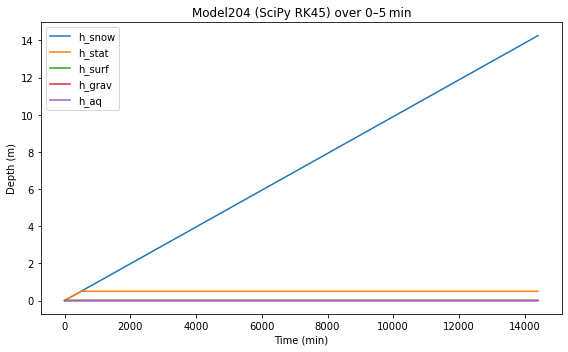

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ───────── HamonPET ─────────
def HamonPET(temperature, latitude, doy):
    """
    Port of ETMethods::HamonPET from C++.
    temperature: °C
    latitude:    degrees
    doy:         day-of-year (1..365)
    Returns PET in m/min.
    """
    PET = 0.0
    if temperature > 0.0:
        # saturation vapor pressure (mb)
        esat = 6.108 * np.exp((17.26939 * temperature) / (temperature + 237.3))
        # saturated water vapor density (g/m³)
        Wt = 216.7 * esat / (temperature + 273.3)

        # daylight fraction D (normalized to 12h) via CBM model
        theta = 0.2163108 + 2.0 * np.arctan(0.9671396 * np.tan(0.00860 * (doy - 186.0)))
        phi   = np.arcsin(0.39795 * np.cos(theta))
        PI    = np.pi
        # compute day length fraction (in units of 12 h)
        num = (np.sin(0.8333 * PI/180.0) + 
               np.sin(latitude * PI/180.0) * np.sin(phi))
        den = (np.cos(latitude * PI/180.0) * np.cos(phi))
        # guard against acos domain error
        arg = np.clip(num/den, -1.0, 1.0)
        D = (24.0 - (24.0/PI) * np.arccos(arg)) / 12.0

        # Arctic handling (if acos argument was OOB)
        if np.isnan(D):
            D = 0.0
            if (phi > 0 and latitude > 0) or (phi < 0 and latitude < 0):
                D = 2.0

        # PET [m/min]
        PET = 1.6169e-6 * D * D * Wt * 60.0 / 1000.0

    return PET

# ───────── ETactual ─────────
def ETactual(Emax, s, sw, ss):
    """
    Port of ETMethods::ETactual from C++.
    Emax:  maximum potential ET
    s:     saturation fraction = h_stat / Hu
    sw, ss: wilting-point and saturation
    """
    ETa = 0.0
    if s > sw and s <= ss:
        ETa = Emax * (s - sw) / (ss - sw)
    elif s > ss:
        ETa = Emax
    return ETa

# ───────── soiltemp (if ever needed) ─────────
def soiltemp(Tair, Tz, Ds):
    """
    Port of SoilTemp::soiltemp from C++.
    Tair: air temp (°C), Tz: previous soil temp (°C), Ds: snow depth (m)
    Returns new soil temperature at mid-layer.
    """
    Cs   = 1e6
    Kt   = 0.516
    Cice = 8.93e6
    fs   = -2.7
    Zs   = 3.5e-2
    dt   = 3600.0*24.0
    CA   = Cs + Cice
    f    = dt * Kt / (CA * (2*Zs)*(2*Zs))

    T_star = Tz + f*(Tair - Tz)
    Tz_out = T_star * np.exp(-fs * Ds)
    return Tz_out

# ───────── Model204 RHS ─────────
def model204_rhs(t, y):
    h_snow, h_stat, h_surf, h_grav, h_aq = y

    # spatial parameters (stubs)
    c1     = 0.001/60.0
    infil  = 0.0001*c1
    perco  = 0.00005*c1
    Hu     = 0.5
    lat    = 45.0
    sw, ss = 0.2, 0.8
    n_mann = 0.03
    slope  = 0.05
    L      = 1000.0
    A_h    = 1e5
    alpha3 = 2*24*60
    alpha4 = 5*24*60
    melt_f = 0.00001
    temp_thr = 0.0

    # forcings
    rainfall    = 0.001
    temperature = 1.0
    doy         = 1.0 + t/1440.0

    # 1) Snow
    snowmelt = min(h_snow, temperature*melt_f) if temperature>=temp_thr else 0.0
    x1       = rainfall + snowmelt
    dh_snow  = rainfall - snowmelt

    # 2) Static
    x2      = max(0.0, x1 + h_stat - Hu)
    d1      = x1 - x2
    e_pot   = HamonPET(temperature, lat, doy)
    Emax    = min(e_pot, h_stat)
    s       = h_stat / Hu
    out1    = ETactual(Emax, s, sw, ss)
    dh_stat = d1 - out1

    # 3) Surface
    x3      = min(x2, infil)
    d2      = x2 - x3
    alfa2   = (1.0/n_mann) * h_surf**(2.0/3.0) * np.sqrt(slope)
    w       = min(1.0, alfa2*L/A_h*60.0)
    out2    = h_surf * w
    dh_surf = d2 - out2

    # 4) Gravitational
    x4      = min(x3, perco)
    d3      = x3 - x4
    out3    = (h_grav/alpha3) if alpha3>=1.0 else 0.0
    dh_grav = d3 - out3

    # 5) Aquifer
    d4      = x4
    out4    = (h_aq/alpha4) if alpha4>=1.0 else 0.0
    dh_aq   = d4 - out4

    return [dh_snow, dh_stat, dh_surf, dh_grav, dh_aq]


# ───────── Simulation (0–5 min) ─────────
t0 = 0.0
tf = 10.0 * 24.0 * 60.0
num_steps = int((tf - t0)/0.5) + 1
t_eval = np.linspace(t0, tf, num_steps)
y0 = [0,0,0,0,0]

sol = solve_ivp(model204_rhs, (t0,tf), y0,
                method='RK45', t_eval=t_eval,
                rtol=1e-6, atol=1e-9)

# ───────── Plot ─────────
plt.figure(figsize=(8,5))
labels = ['h_snow','h_stat','h_surf','h_grav','h_aq']
for i, lab in enumerate(labels):
    plt.plot(sol.t, sol.y[i], label=lab)
plt.xlabel('Time (min)')
plt.ylabel('Depth (m)')
plt.title('Model204 (SciPy RK45) over 0–5 min')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_562987/2103170942.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


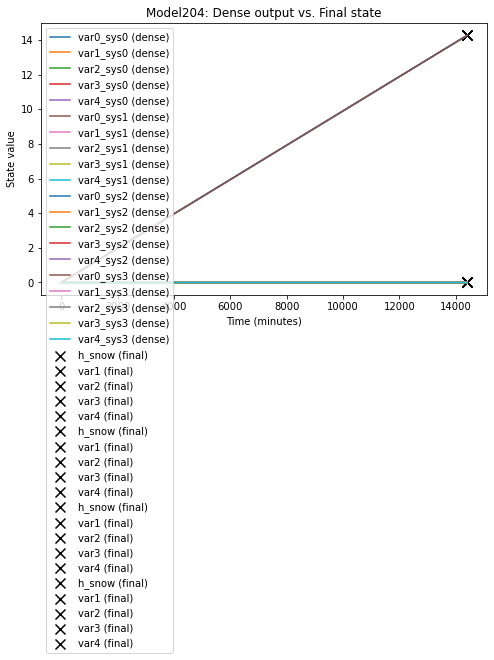

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
dense_df = pd.read_csv('dense_204.csv')
final_df = pd.read_csv('final_204.csv')

time = dense_df["time"]

plt.figure(figsize=(8, 5))

# 1) Plot dense time series
for col in dense_df.columns:
    if col == "time":
        continue
    plt.plot(time, dense_df[col], label=f"{col} (dense)")

# 2) Overlay final state as black crosses at t_last
t_last = time.iloc[-1]
for col in dense_df.columns:
    if col == "time":
        continue
    # extract component index from "var0_sys0" etc.
    comp = int(col.split('_')[0][3:])
    final_col = "h_snow" if comp == 0 else f"var{comp}"
    final_val = final_df[final_col].iloc[0]
    plt.scatter([t_last], [final_val],
                marker='x', s=100, color='black',
                label=f"{final_col} (final)")

plt.xlabel("Time (minutes)")
plt.ylabel("State value")
plt.title("Model204: Dense output vs. Final state")
plt.legend()
plt.tight_layout()
plt.show()
